# Import Library

In [38]:
!pip install keras_tuner

In [39]:
import os
import shutil
import holidays
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from google.colab import drive

# Library Statistik untuk EDA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Preprocessing & Metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

# Deep Learning (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Tuning
import keras_tuner as kt

print("Library berhasil diimpor.")

Library berhasil diimpor.


# Data Preparation

## Load Data

In [40]:
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/Magang Prima PTKI/data_dummy'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# Load Data
transactions_df = pd.read_csv(os.path.join(base_path, 'transactions.csv'))
transaction_details_df = pd.read_csv(os.path.join(base_path, 'transaction_details.csv'))
products_df = pd.read_csv(os.path.join(base_path, 'products.csv'))
stores_df = pd.read_csv(os.path.join(base_path, 'stores.csv'))

## Merging Data

In [42]:
# Merging
df_merged = pd.merge(transactions_df, transaction_details_df, left_on='id', right_on='transactionId')
df_merged = pd.merge(df_merged, products_df[['id', 'productCategoryId']], left_on='productId', right_on='id', suffixes=('', '_prod'))
df_merged = pd.merge(df_merged, stores_df[['id', 'storeTypeId']], left_on='storeId', right_on='id', suffixes=('', '_store'))

In [43]:
# Filter Store ID 2 (Skincare/Beauty)
TARGET_STORE_ID = 2
df_beauty = df_merged[df_merged['storeId'] == TARGET_STORE_ID].copy()
df_beauty['transactionDate'] = pd.to_datetime(df_beauty['transactionDate'])

## Data Cleaning

In [44]:
# Agregasi Harian
time_series_beauty = df_beauty.groupby(df_beauty['transactionDate'].dt.date)['subtotal'].sum().reset_index()
time_series_beauty.columns = ['date', 'revenue']
time_series_beauty['date'] = pd.to_datetime(time_series_beauty['date'])
time_series_beauty.set_index('date', inplace=True)

In [45]:
# Reindex agar tanggal berurutan
all_days = pd.date_range(start=time_series_beauty.index.min(), end=time_series_beauty.index.max(), freq='D')
time_series_beauty = time_series_beauty.reindex(all_days, fill_value=0)

In [46]:
# Handling Outliers (Clipping)
Q1 = time_series_beauty['revenue'].quantile(0.25)
Q3 = time_series_beauty['revenue'].quantile(0.75)
IQR = Q3 - Q1
time_series_beauty['revenue_clean'] = time_series_beauty['revenue'].clip(lower=Q1 - 1.5*IQR, upper=Q3 + 1.5*IQR)

print(f"Data Beauty (Store {TARGET_STORE_ID}) berhasil dibersihkan.")

Data Beauty (Store 2) berhasil dibersihkan.


# Exploratory Data Analysis (EDA)

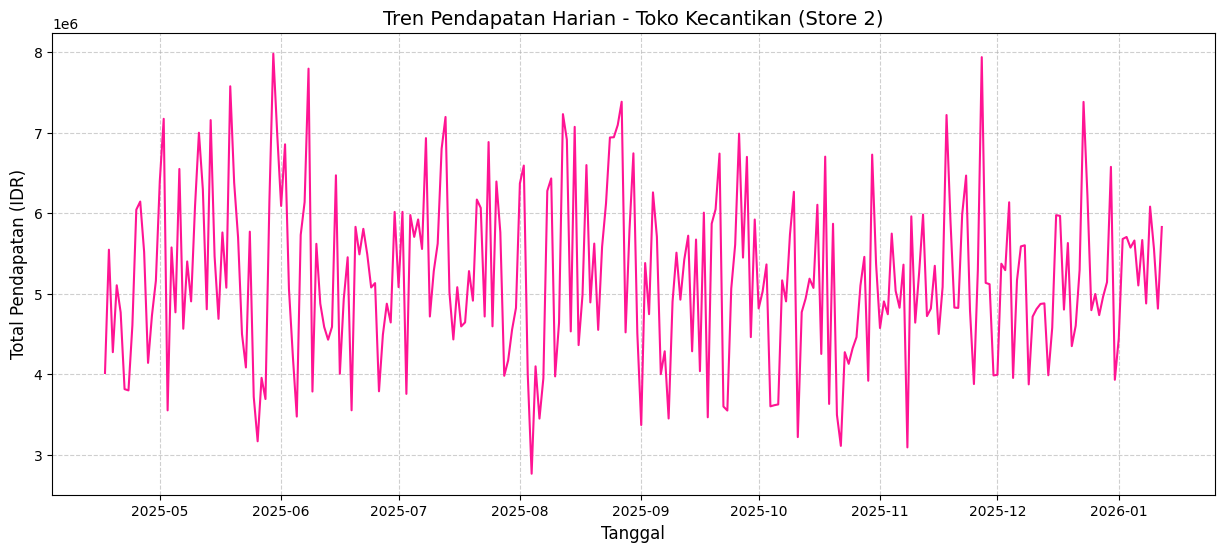

In [47]:
# 1. Tren Pendapatan Harian
plt.figure(figsize=(15, 6))
plt.plot(time_series_beauty.index, time_series_beauty['revenue_clean'], color='deeppink', linewidth=1.5)
plt.title('Tren Pendapatan Harian - Toko Kecantikan (Store 2)', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Total Pendapatan (IDR)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

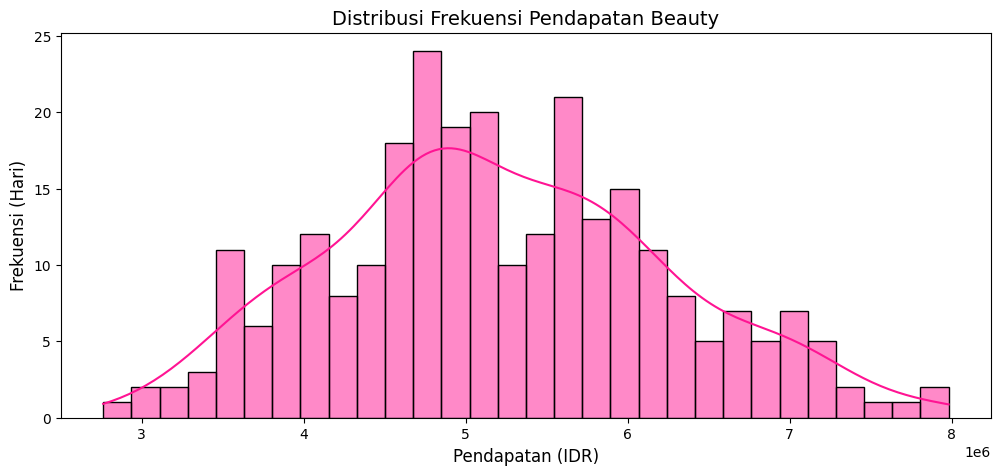

In [48]:
# 2. Distribusi Pendapatan
plt.figure(figsize=(12, 5))
sns.histplot(time_series_beauty['revenue_clean'], kde=True, color='deeppink', bins=30)
plt.title('Distribusi Frekuensi Pendapatan Beauty', fontsize=14)
plt.xlabel('Pendapatan (IDR)', fontsize=12)
plt.ylabel('Frekuensi (Hari)', fontsize=12)
plt.show()

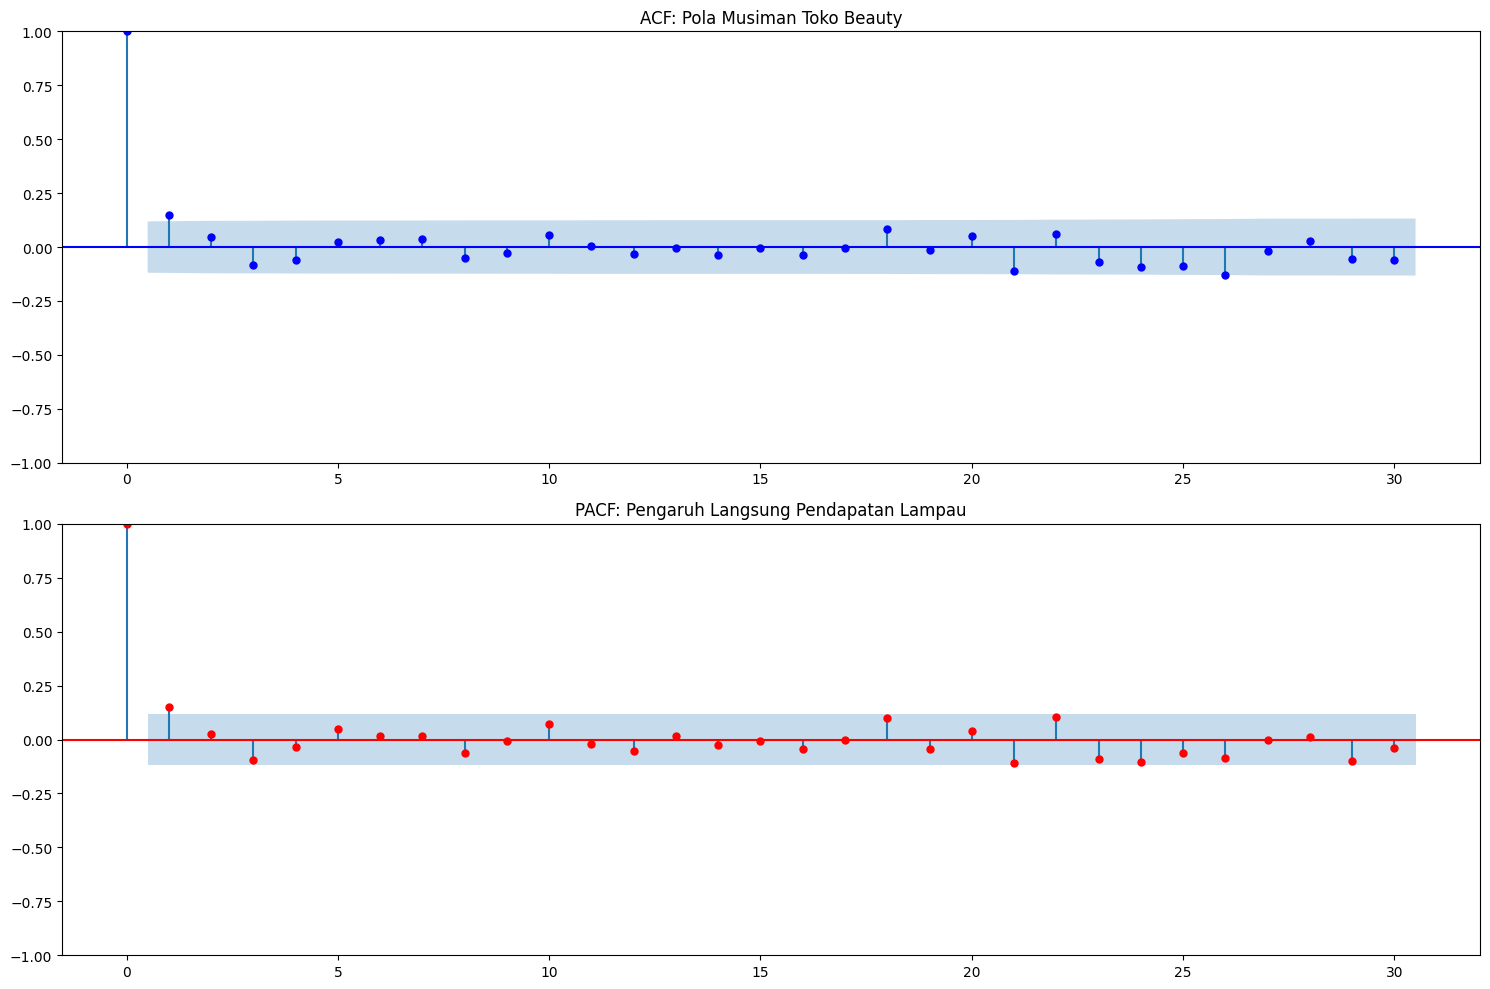

In [49]:
# 3. ACF & PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(time_series_beauty['revenue_clean'], lags=30, ax=ax1, color='blue')
ax1.set_title('ACF: Pola Musiman Toko Beauty', fontsize=12)
plot_pacf(time_series_beauty['revenue_clean'], lags=30, ax=ax2, color='red')
ax2.set_title('PACF: Pengaruh Langsung Pendapatan Lampau', fontsize=12)
plt.tight_layout()
plt.show()

/tmp/ipython-input-508541739.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='day_name', y='revenue_clean', data=time_series_beauty, order=order, palette='husl')


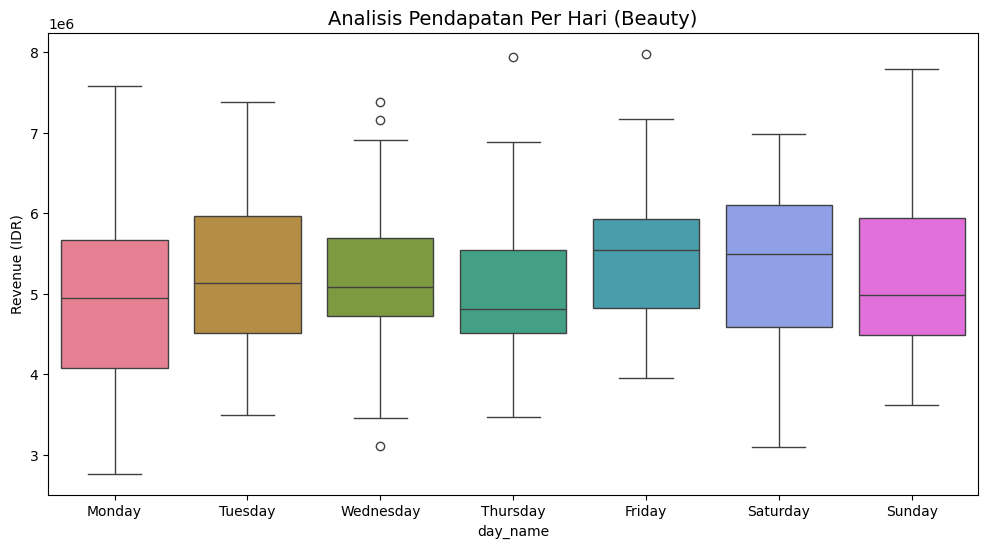

In [50]:
# 4. Boxplot Hari dalam Seminggu
time_series_beauty['day_name'] = time_series_beauty.index.day_name()
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_name', y='revenue_clean', data=time_series_beauty, order=order, palette='husl')
plt.title('Analisis Pendapatan Per Hari (Beauty)', fontsize=14)
plt.ylabel('Revenue (IDR)')
plt.show()

In [51]:
# 5. Ringkasan Statistik
stats = time_series_beauty['revenue_clean'].describe()
print("="*45)
print("   RINGKASAN STATISTIK PENDAPATAN BEAUTY")
print("="*45)
print(f"Rata-rata Harian    : Rp {stats['mean']:,.2f}")
print(f"Standar Deviasi     : Rp {stats['std']:,.2f}")
print(f"Median (P50)        : Rp {stats['50%']:,.2f}")
print(f"Maksimum            : Rp {stats['max']:,.2f}")
print("="*45)

   RINGKASAN STATISTIK PENDAPATAN BEAUTY
Rata-rata Harian    : Rp 5,205,662.36
Standar Deviasi     : Rp 1,034,618.31
Median (P50)        : Rp 5,100,000.00
Maksimum            : Rp 7,980,500.00


# Preprocessing Data

## Feature Engineering

(Menambah Konteks Waktu)

In [52]:
# A. Fitur Hari Libur
id_holidays = holidays.Indonesia(years=[2025, 2026])
time_series_beauty['is_holiday'] = time_series_beauty.index.strftime('%Y-%m-%d').isin(id_holidays).astype(int)

# B. Fitur Payday (tgl 25 - 5)
time_series_beauty['is_payday'] = time_series_beauty.index.day.map(lambda x: 1 if x >= 25 or x <= 5 else 0)

# C. Fitur Weekend
time_series_beauty['is_weekend'] = time_series_beauty.index.weekday.map(lambda x: 1 if x >= 5 else 0)

In [53]:
# D. Fitur Lag 1-7 (Kunci Akurasi)
for i in range(1, 8):
    time_series_beauty[f'lag_{i}'] = time_series_beauty['revenue_clean'].shift(i)

In [54]:
# E. Fitur Tren (Rolling Average)
time_series_beauty['rolling_avg_7d'] = time_series_beauty['revenue_clean'].rolling(window=7).mean()

In [55]:
# Update Feature Engineering (Menambah Day of Month)
time_series_beauty['day_of_month'] = time_series_beauty.index.day

In [56]:
# F. Drop NaN
time_series_beauty.dropna(inplace=True)

## Scaling

In [57]:
# Definisikan X dan y
features = [f'lag_{i}' for i in range(1, 8)] + ['is_holiday', 'is_payday', 'is_weekend', 'rolling_avg_7d', 'day_of_month']
X_raw = time_series_beauty[features]
y_raw = time_series_beauty['revenue_clean']

In [58]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [59]:
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw.values.reshape(-1, 1))

In [60]:
# Reshaping ke 3D (Samples, Time Steps=1, Features=11)
X_final = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
y_final = y_scaled

## Splitting Data (Train & Test)

In [61]:
# Data Splitting (80/20)
train_size = int(len(X_final) * 0.8)
X_train, X_test = X_final[:train_size], X_final[train_size:]
y_train, y_test = y_final[:train_size], y_final[train_size:]

print(f"Preprocessing Selesai. Shape X_train: {X_train.shape}")

Preprocessing Selesai. Shape X_train: (211, 1, 12)


# Modeling

In [62]:
def model_builder(hp):
    model = Sequential()

    # CNN Layer
    model.add(Conv1D(
        filters=hp.Int("conv_filters", 32, 128, 16),
        kernel_size=1,
        activation='relu',
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(MaxPooling1D(pool_size=1))

    # Bi-LSTM Layer
    model.add(Bidirectional(LSTM(units=hp.Int("bilstm_units", 64, 256, 32), return_sequences=True)))
    model.add(Dropout(hp.Float("dropout_1", 0.1, 0.4, 0.1)))

    # LSTM 2
    model.add(LSTM(units=hp.Int("lstm_units", 32, 128, 32), return_sequences=False))

    # Dense Output
    model.add(Dense(hp.Int("dense_units", 32, 128, 32), activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Reset Tuner Khusus Beauty
tuner_path = 'tuner_dir/beauty_tuning'
if os.path.exists(tuner_path):
    shutil.rmtree(tuner_path)

tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10,
    directory='tuner_dir',
    project_name='beauty_tuning',
    overwrite=True
)

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

print("Memulai Hyperparameter Tuning untuk Toko Beauty...")
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop])

# Ambil Model Terbaik
best_model = tuner.get_best_models(num_models=1)[0]
print("\nTuning Selesai. Model terbaik telah dipilih.")
best_model.summary()

Trial 10 Complete [00h 00m 26s]
val_loss: 0.015345480293035507

Best val_loss So Far: 0.012799798510968685
Total elapsed time: 00h 03m 46s

Tuning Selesai. Model terbaik telah dipilih.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 96)          │         1,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 384)         │       443,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 384)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        53,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 502,881 (1.92 MB)

 Trainable params: 502,881 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

# Evaluation & Visualization

In [63]:
# 1. Pelatihan Akhir Model Terbaik
print("Melatih model terbaik dengan arsitektur terpilih...")
history = best_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Melatih model terbaik dengan arsitektur terpilih...
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 0.0132 - mae: 0.0918 - val_loss: 0.0146 - val_mae: 0.0934
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0067 - mae: 0.0657 - val_loss: 0.0143 - val_mae: 0.0926
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0070 - mae: 0.0688 - val_loss: 0.0120 - val_mae: 0.0834
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0042 - mae: 0.0518 - val_loss: 0.0119 - val_mae: 0.0822
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0044 - mae: 0.0532 - val_loss: 0.0111 - val_mae: 0.0793
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0037 - mae: 0.0492 - val_loss: 0.0107 - val_mae: 0.0804
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0039 - mae: 0.0516 - val_loss: 0.0117 - val_mae: 0.0825
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0035 - mae: 0.0480 - val_loss: 0.0101 - val_mae: 0.0779
Epo

In [64]:
# 2. Melakukan Prediksi pada Data Uji
y_pred_scaled = best_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


In [65]:
# 3. Inverse Scale (Kembalikan ke nilai Rupiah asli)
y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()
y_actual = scaler_y.inverse_transform(y_test).ravel()

In [66]:
# 4. Hitung Metrik Evaluasi (MAE & MAPE)
mae = mean_absolute_error(y_actual, y_pred)
mape = mean_absolute_percentage_error(y_actual, y_pred) * 100
r2 = r2_score(y_actual, y_pred)

In [67]:
print("="*40)
print("   HASIL EVALUASI MODEL BEAUTY (STORE 2)")
print("="*40)
print(f"Mean Absolute Error (MAE)  : Rp {mae:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE) : {mape:.2f}%")
print(f"R2-Score (Goodness of Fit) : {r2:.4f}")
print("="*40)

   HASIL EVALUASI MODEL BEAUTY (STORE 2)
Mean Absolute Error (MAE)  : Rp 210,588.86
Mean Absolute Percentage Error (MAPE) : 4.00%
R2-Score (Goodness of Fit) : 0.9044


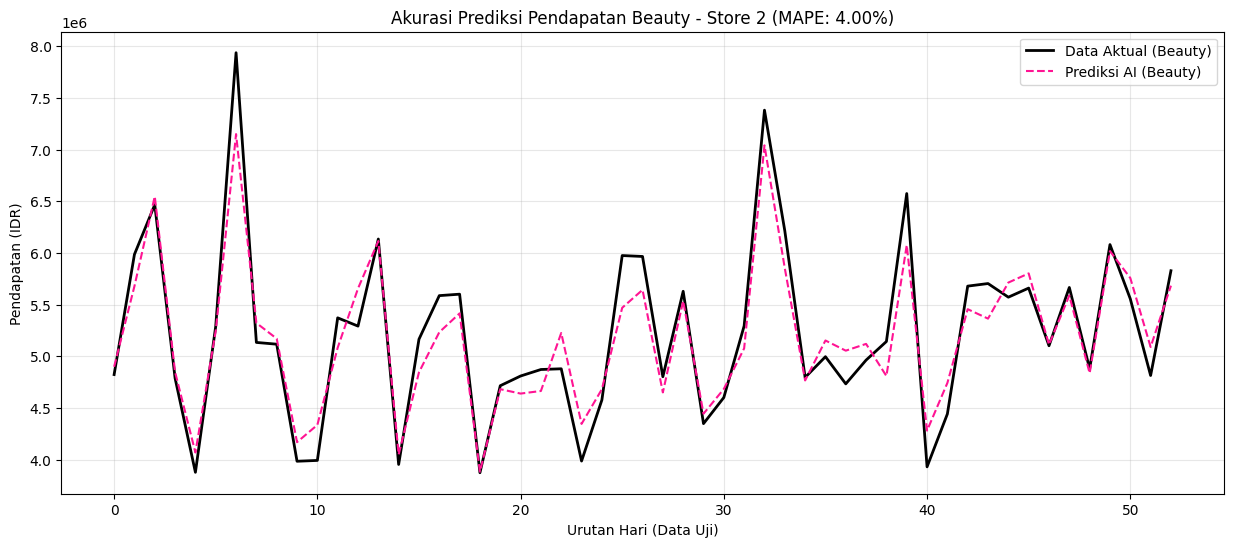

In [68]:
# 5. Visualisasi Prediksi vs Aktual
plt.figure(figsize=(15, 6))
plt.plot(y_actual, label='Data Aktual (Beauty)', color='black', linewidth=2)
plt.plot(y_pred, label='Prediksi AI (Beauty)', color='deeppink', linestyle='--')
plt.title(f'Akurasi Prediksi Pendapatan Beauty - Store 2 (MAPE: {mape:.2f}%)')
plt.ylabel('Pendapatan (IDR)')
plt.xlabel('Urutan Hari (Data Uji)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

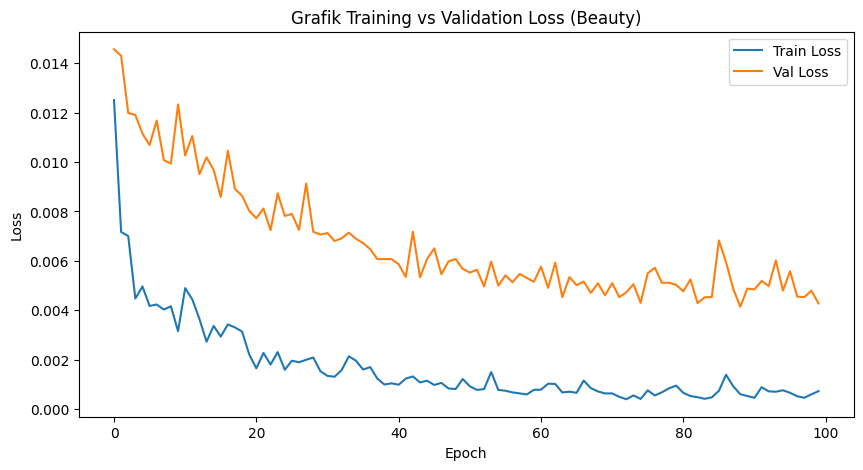

In [69]:
# 6. Visualisasi Training Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Grafik Training vs Validation Loss (Beauty)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save Model

In [70]:
# Simpan Model & Scaler Beauty
model_path = '/content/drive/MyDrive/Magang Prima PTKI/models/beauty/model_beauty_store_2.keras'
os.makedirs(os.path.dirname(model_path), exist_ok=True)
best_model.save(model_path)
joblib.dump(scaler_X, '/content/drive/MyDrive/Magang Prima PTKI/models/beauty/scaler_X_beauty.pkl')
joblib.dump(scaler_y, '/content/drive/MyDrive/Magang Prima PTKI/models/beauty/scaler_y_beauty.pkl')

['/content/drive/MyDrive/Magang Prima PTKI/models/beauty/scaler_y_beauty.pkl']

# Kode Inference Dengan Analisis Bisnis

In [71]:
# 1. Load Model & Scaler
model = load_model('/content/drive/MyDrive/Magang Prima PTKI/models/beauty/model_beauty_store_2.keras')
scaler_X = joblib.load('/content/drive/MyDrive/Magang Prima PTKI/models/beauty/scaler_X_beauty.pkl')
scaler_y = joblib.load('/content/drive/MyDrive/Magang Prima PTKI/models/beauty/scaler_y_beauty.pkl')

In [72]:
def get_forecast_7_days_stabilized_beauty(model, df_historical, scaler_X, scaler_y):
    # Ambil data 7 hari terakhir
    current_lags = df_historical['revenue_clean'].tail(7).tolist()

    # Hitung rata-rata per hari dalam seminggu (Stabilizer pola mingguan)
    weekly_pattern = df_historical.groupby(df_historical.index.dayofweek)['revenue_clean'].mean()

    predictions = []
    dates = []
    last_date = df_historical.index[-1]
    id_holidays = holidays.Indonesia(years=[last_date.year, last_date.year + 1])

    print("="*60)
    print(f"   PREDIKSI OPERASIONAL BEAUTY TERSTABILISASI (7 HARI)")
    print(f"   (Batas Data: {last_date.strftime('%d %b %Y')})")
    print("="*60)

    for i in range(1, 8):
        current_date = last_date + timedelta(days=i)
        day_idx = current_date.weekday()

        # Fitur Engineering
        is_holiday = 1 if current_date.strftime('%Y-%m-%d') in id_holidays else 0
        is_payday = 1 if current_date.day >= 25 or current_date.day <= 5 else 0
        is_weekend = 1 if day_idx >= 5 else 0
        rolling_avg = np.mean(current_lags)
        day_of_month = current_date.day

        # Susun fitur (12 fitur)
        input_row = current_lags + [is_holiday, is_payday, is_weekend, rolling_avg, day_of_month]

        # Scaling & Prediksi
        input_scaled = scaler_X.transform([input_row])
        input_final = input_scaled.reshape((1, 1, len(features)))
        pred_scaled = model.predict(input_final, verbose=0)
        raw_pred = scaler_y.inverse_transform(pred_scaled)[0][0]

        # --- LOGIKA "REM" (STABILIZER) ---
        # Mencampur hasil AI (70%) dengan rata-rata historis hari tersebut (30%)
        avg_hist_day = weekly_pattern[day_idx]
        stabilized_pred = (raw_pred * 0.7) + (avg_hist_day * 0.3)

        # Clipping: Mencegah angka melompat di luar batas wajar (max 120% rekor historis)
        max_limit = df_historical['revenue_clean'].max() * 1.2
        final_pred = min(stabilized_pred, max_limit)

        predictions.append(final_pred)
        dates.append(current_date)

        # Update Lags untuk iterasi berikutnya
        current_lags.pop(0)
        current_lags.append(final_pred)

        # Status berdasarkan rata-rata statistik toko kecantikan
        status = "RAMAI" if final_pred > stats['mean'] * 1.1 else "NORMAL"
        print(f"{current_date.strftime('%A, %d %b')}: Rp {final_pred:,.0f} | {status}")

    return pd.DataFrame({'date': dates, 'pred_revenue': predictions}).set_index('date')

In [73]:
# Jalankan Proyeksi Baru untuk Beauty
forecast_results_stable_beauty = get_forecast_7_days_stabilized_beauty(best_model, time_series_beauty, scaler_X, scaler_y)

   PREDIKSI OPERASIONAL BEAUTY TERSTABILISASI (7 HARI)
   (Batas Data: 12 Jan 2026)
Tuesday, 13 Jan: Rp 5,629,956 | NORMAL
Wednesday, 14 Jan: Rp 5,462,976 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Thursday, 15 Jan: Rp 5,294,317 | NORMAL
Friday, 16 Jan: Rp 6,297,234 | RAMAI
Saturday, 17 Jan: Rp 5,862,230 | RAMAI


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Sunday, 18 Jan: Rp 5,680,754 | NORMAL
Monday, 19 Jan: Rp 5,417,733 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


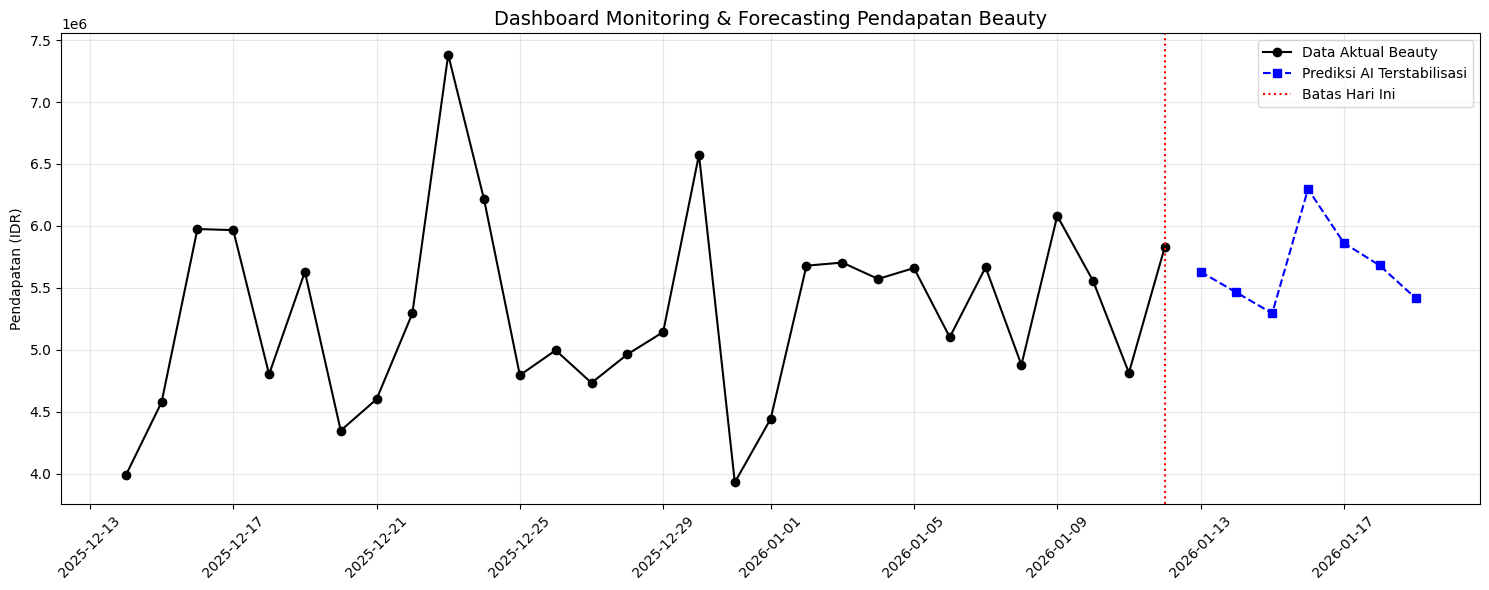

In [74]:
# Visualisasi Dashboard Beauty
plt.figure(figsize=(15, 6))
hist_data_beauty = time_series_beauty.tail(30)

plt.plot(hist_data_beauty.index, hist_data_beauty['revenue_clean'],
         label='Data Aktual Beauty', color='black', marker='o')

plt.plot(forecast_results_stable_beauty.index, forecast_results_stable_beauty['pred_revenue'],
         label='Prediksi AI Terstabilisasi', color='blue', linestyle='--', marker='s')

plt.axvline(x=hist_data_beauty.index[-1], color='red', linestyle=':', label='Batas Hari Ini')
plt.title('Dashboard Monitoring & Forecasting Pendapatan Beauty', fontsize=14)
plt.ylabel('Pendapatan (IDR)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()